In [1]:
import sys
print(sys.executable)
neural_struct_dir = '/mnt/g/PythonWorkspace/neural-structural-optimization/'
sys.path.insert(0, neural_struct_dir)
# hardcoded
cur_file_dir = '/mnt/g/PythonWorkspace/neural-structural-optimization/projects'
sys.path.insert(0, cur_file_dir)

/home/shushu/install/anaconda3/envs/neural-struct/bin/python


In [2]:
import matplotlib.pyplot as plt
import xarray
import tensorflow as tf
import time
import os
import pandas as pd

from neural_structural_optimization import problems
from neural_structural_optimization import topo_api
from neural_structural_optimization import train
from neural_structural_optimization.models import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

2021-08-19 17:39:25.621132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-19 17:39:25.621177: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
problem_mbb = problems.mbb_beam(width=64, height=32, density=0.5)
args_mbb = topo_api.specified_task(problem_mbb)

## activation->normalization->conv

In [46]:
def FlatConv3(inputs, filters, activation=layers.Activation(tf.nn.relu)):
    he_normal = tf.keras.initializers.HeNormal()
    net = layers.Conv2D(filters, 3, padding='same', kernel_initializer=he_normal)(inputs)
    return net

def UpConv4(inputs, filters, activation=layers.Activation(tf.nn.relu)):
    he_normal = tf.keras.initializers.HeNormal()
    net = layers.Conv2DTranspose(filters, 4, strides=(2,2),padding='same', kernel_initializer=he_normal)(inputs)
    return net

In [47]:
class CNNSketch3(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size = 128,
      dense_channels = 32,
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation = tf.nn.tanh,
      normalization=global_normalization,
      volume_contraint = True,
      cone_filter = True
  ):
    super().__init__(seed, args, volume_contraint, cone_filter)

    activation = layers.Activation(activation)

    h = self.env.args['nely'] // 2
    w = self.env.args['nelx'] // 2
    
    net = inputs = layers.Input((latent_size,), batch_size=1)
    filters = h * w * dense_channels   # 32 * h/2 * w/2
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)
    net = layers.Reshape([h, w, dense_channels])(net)  
    
    net = activation(net)
    net = normalization(net)
    net = FlatConv3(net, 32, activation)  # 32 * h/2 * w/2

    net = activation(net)
    net = normalization(net)
    net = UpConv4(net, 16, activation)  # 16 * h * w
    
    net = activation(net)
    net = normalization(net)
    net = FlatConv3(net, 1, activation)  # 1 * h * w
    
    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [48]:
cnns3_mbb1 = CNNSketch3(args=args_mbb, volume_contraint=True, cone_filter = True)
tic = time.perf_counter()
ds_cnns3_mbb1 = train.train_lbfgs(cnns3_mbb1, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 26.30s


## activation->conv->normalization

In [49]:
class CNNSketch3(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size = 128,
      dense_channels = 32,
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation = tf.nn.tanh,
      normalization=global_normalization,
      volume_contraint = True,
      cone_filter = True
  ):
    super().__init__(seed, args, volume_contraint, cone_filter)

    activation = layers.Activation(activation)

    h = self.env.args['nely'] // 2
    w = self.env.args['nelx'] // 2
    
    net = inputs = layers.Input((latent_size,), batch_size=1)
    filters = h * w * dense_channels   # 32 * h/2 * w/2
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)
    net = layers.Reshape([h, w, dense_channels])(net)  
    
    net = activation(net)
    net = FlatConv3(net, 32, activation)  # 32 * h/2 * w/2
    net = normalization(net)

    net = activation(net)
    net = UpConv4(net, 16, activation)  # 16 * h * w
    net = normalization(net)

    net = activation(net)
    net = FlatConv3(net, 1, activation)  # 1 * h * w
    
    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [50]:
cnns3_mbb2 = CNNSketch3(args=args_mbb, volume_contraint=True, cone_filter = True)
tic = time.perf_counter()
ds_cnns3_mbb2 = train.train_lbfgs(cnns3_mbb2, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 26.47s


## conv->activation->normalization

In [51]:
class CNNSketch3(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size = 128,
      dense_channels = 32,
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation = tf.nn.tanh,
      normalization=global_normalization,
      volume_contraint = True,
      cone_filter = True
  ):
    super().__init__(seed, args, volume_contraint, cone_filter)

    activation = layers.Activation(activation)

    h = self.env.args['nely'] // 2
    w = self.env.args['nelx'] // 2
    
    net = inputs = layers.Input((latent_size,), batch_size=1)
    filters = h * w * dense_channels   # 32 * h/2 * w/2
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)
    net = layers.Reshape([h, w, dense_channels])(net)  
    
    net = FlatConv3(net, 32, activation)  # 32 * h/2 * w/2
    net = activation(net)
    net = normalization(net)

    net = UpConv4(net, 16, activation)  # 16 * h * w
    net = activation(net)
    net = normalization(net)

    net = FlatConv3(net, 1, activation)  # 1 * h * w
    
    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [52]:
cnns3_mbb3 = CNNSketch3(args=args_mbb, volume_contraint=True, cone_filter = True)
tic = time.perf_counter()
ds_cnns3_mbb3 = train.train_lbfgs(cnns3_mbb3, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 28.82s


## conv->normalization->activation

In [57]:
class CNNSketch3(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size = 128,
      dense_channels = 32,
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation = tf.nn.tanh,
      normalization=global_normalization,
      volume_contraint = True,
      cone_filter = True
  ):
    super().__init__(seed, args, volume_contraint, cone_filter)

    activation = layers.Activation(activation)

    h = self.env.args['nely'] // 2
    w = self.env.args['nelx'] // 2
    
    net = inputs = layers.Input((latent_size,), batch_size=1)
    filters = h * w * dense_channels   # 32 * h/2 * w/2
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)
    net = layers.Reshape([h, w, dense_channels])(net)  
        
    net = FlatConv3(net, 32, activation)  # 32 * h/2 * w/2
    net = normalization(net)
    net = activation(net)

    net = UpConv4(net, 16, activation)  # 16 * h * w
    net = normalization(net)
    net = activation(net)

    net = FlatConv3(net, 1, activation)  # 1 * h * w
    
    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [58]:
cnns3_mbb4 = CNNSketch3(args=args_mbb, volume_contraint=True, cone_filter = True)
tic = time.perf_counter()
ds_cnns3_mbb4 = train.train_lbfgs(cnns3_mbb4, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 27.19s


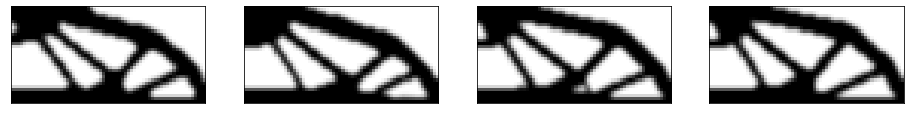

In [64]:
fig, ax = plt.subplots(1, 4, figsize=(16,12),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(ds_cnns3_mbb1.design.sel(step=100), cmap='Greys')
ax[1].imshow(ds_cnns3_mbb2.design.sel(step=100), cmap='Greys')
ax[2].imshow(ds_cnns3_mbb3.design.sel(step=100), cmap='Greys')
ax[3].imshow(ds_cnns3_mbb4.design.sel(step=100), cmap='Greys')

Text(0.5, 0, 'Optimization step')

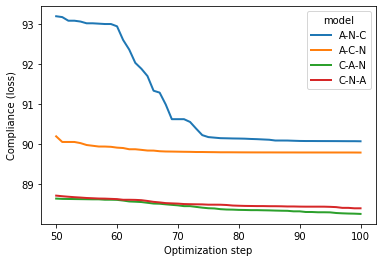

In [63]:
dims = pd.Index(['A-N-C', 'A-C-N', 'C-A-N', 'C-N-A'], name='model')
ds =  xarray.concat([ds_cnns3_mbb1, ds_cnns3_mbb2, ds_cnns3_mbb3, ds_cnns3_mbb4], dim=dims)
ds.loss.transpose().to_pandas().cummin().loc[50:100].plot(linewidth=2)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')